In [1]:
import pandas as pd
train_df = pd.read_csv('train.tsv', sep='\t')
val_df = pd.read_csv('val.tsv', sep='\t')

In [2]:
print('Train real news:', train_df[train_df['label']==1].shape[0])
print('Train fake news:', train_df[train_df['label']==0].shape[0])
print('Train AI news:', train_df[train_df['label']==2].shape[0])

print('Val real news:', val_df[val_df['label']==1].shape[0])
print('Val fake news:', val_df[val_df['label']==0].shape[0])
print('Val AI news:', val_df[val_df['label']==2].shape[0])

Train real news: 34697
Train fake news: 25072
Train AI news: 64327
Val real news: 8675
Val fake news: 6268
Val AI news: 16082


In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
stop_words = stopwords.words('english')
stop_words.remove('not')
lemmatizer = WordNetLemmatizer()

In [4]:
def data_preprocessing(review):
    
    # data cleaning
    review = re.sub(re.compile('<.*?>'), '', review) # remove html tags
    review = re.sub('[^A-Za-z0-9]+', ' ', review) # taking only words
    
    # lowercase
    review = review.lower()
    
    # tokenization
    tokens = nltk.word_tokenize(review)
    
    # stop word removal
    review = [word for word in tokens if word not in stop_words]
    
    # lemmatization
    review = [lemmatizer.lemmatize(word) for word in review]
    
    # join words in preprocessed review
    review = ' '.join(review)
    
    return review

In [5]:
train_df['preprocessed_title'] = train_df['title'].apply(lambda review: data_preprocessing(review))
train_df

,title,label,preprocessed_title
0,Etihad flight from Abu Dhabi makes emergency l...,1,etihad flight abu dhabi make emergency landing...
1,: the fbi's russia investigation is 'accelerat...,2,fbi russia investigation accelerating cost com...
2,Turks flock to social media for gold trader sa...,1,turk flock social medium gold trader sanction ...
3,peerless flexible income fund-dividend monthly...,2,peerless flexible income fund dividend monthly...
4,"'larry wilmore, comedy central's incoming nigh...",2,larry wilmore comedy central incoming nightly ...
...,...,...,...
124091,'idfc government securities investment plan di...,2,idfc government security investment plan direc...
124092,'nris would love to see cocktail: saif ali kha...,2,nris would love see cocktail saif ali khan ind...
124093,launches regional-websites network - the econo...,2,launch regional website network economic time ...
124094,HILLARY USES Fake Accent In “Victory” Speech T...,0,hillary us fake accent victory speech attack p...


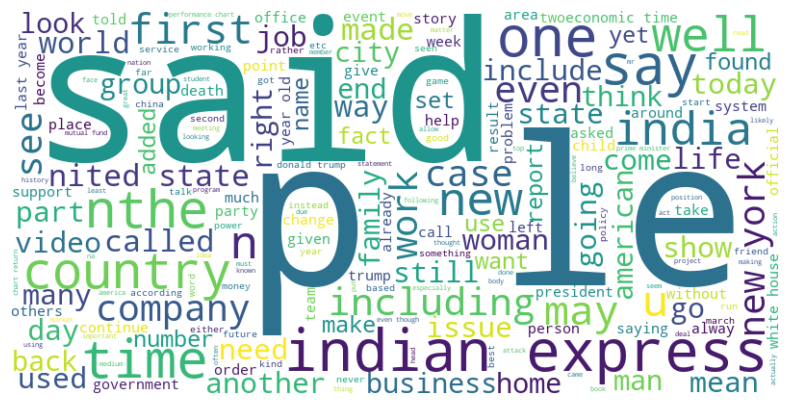

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming train_df is already loaded

# Concatenate all preprocessed titles into a single string
text = " ".join(train_df['preprocessed_title'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [6]:
val_df['preprocessed_title'] = val_df['title'].apply(lambda review: data_preprocessing(review))
val_df

,title,label,preprocessed_title
0,Trump firing of FBI Director Comey evokes crit...,1,trump firing fbi director comey evokes critici...
1,JUST IN: Donald Trump Seriously Thinks Deaf P...,0,donald trump seriously think deaf people retarded
2,Finnish police release one knife attack suspect,1,finnish police release one knife attack suspect
3,Elizabeth Warren Just DECIMATED Ted Cruz For ...,0,elizabeth warren decimated ted cruz whining sa...
4,"Portuguese protest over deadly forest fires, g...",1,portuguese protest deadly forest fire governme...
...,...,...,...
31020,boy scouts of america is sued over sexual abus...,2,boy scout america sued sexual abuse allegation...
31021,Indonesia to bar Myanmar protest at world's bi...,1,indonesia bar myanmar protest world biggest bu...
31022,Kris Jenner Talks Jennifer Lawrence Getting Na...,1,kris jenner talk jennifer lawrence getting nak...
31023,'nick cordero may need lung transplant surgery...,2,nick cordero may need lung transplant surgery ...


In [7]:
X_train = train_df['preprocessed_title']
X_val = val_df['preprocessed_title']

y_train = train_df['label']
y_val = val_df['label']

print('Train data:', X_train.shape, y_train.shape)
print('Test data:', X_val.shape, y_val.shape)


Train data: (124096,) (124096,)
Test data: (31025,) (31025,)


In [8]:
# Vectorizing text data: TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer with your desired parameters
vectorizer = TfidfVectorizer(min_df=10)

# Fit and transform the training data
X_train_news_tfidf = vectorizer.fit_transform(X_train)

# Transform the validation data using the same vocabulary as the training data
X_val_news_tfidf = vectorizer.transform(X_val)

print('X_train_new_tfidf shape:', X_train_news_tfidf.shape)
print('X_test_news_tfidf shape:', X_val_news_tfidf.shape)

X_train_new_tfidf shape: (124096, 27521)
X_test_news_tfidf shape: (31025, 27521)


Naive Bayes model Performance:
Best alpha: 0.1
Accuracy: 0.8727477840451249
Precision: 0.8703052805305631
Recall: 0.8727477840451249
F1-Score: 0.869501605446094


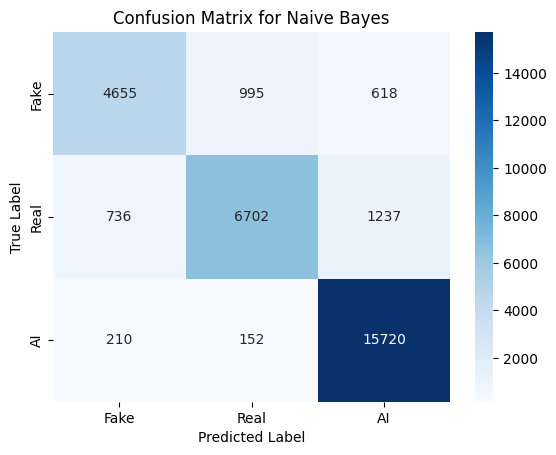

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define the Naive Bayes model
clf = MultinomialNB()

# Define the hyperparameter grid for GridSearch
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0]}

# Perform GridSearch cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_news_tfidf, y_train)

# Get the best hyperparameters
best_alpha = grid_search.best_params_['alpha']

# Train the final model with the best hyperparameters
final_clf = MultinomialNB(alpha=best_alpha)
final_clf.fit(X_train_news_tfidf, y_train)

# Predictions on the validation set
y_pred = final_clf.predict(X_val_news_tfidf)

# Calculate evaluation metrics for multiclass classification
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

# Print evaluation metrics
print('Naive Bayes model Performance:')
print('Best alpha:', best_alpha)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)

# Plot the confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real', 'AI'], yticklabels=['Fake', 'Real', 'AI'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

Random Forest model Performance:
Accuracy: 0.9231587429492345
Precision: 0.9262981750321879
Recall: 0.9231587429492345
F1-Score: 0.9233498899318346


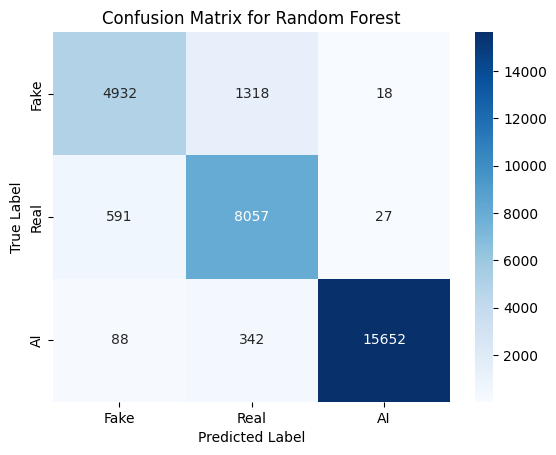

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define the Random Forest model with default parameters
clf = RandomForestClassifier()

# Train the model
clf.fit(X_train_news_tfidf, y_train)

# Predictions on the validation set
y_pred = clf.predict(X_val_news_tfidf)

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

# Print evaluation metrics
print('Random Forest model Performance:')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)

# Plot the confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real', 'AI'], yticklabels=['Fake', 'Real', 'AI'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest')
plt.show()

Logistic Regression Model Performance
Accuracy: 0.9181305398871877
Precision: 0.9200563525247382
Recall: 0.9181305398871877
F1-Score: 0.918309312564785


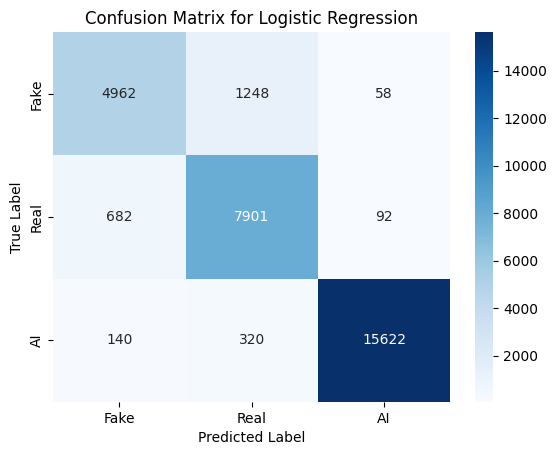

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define the Logistic Regression model
clf = LogisticRegression(max_iter=10000)  # Increase max_iter if necessary

# Train the Logistic Regression model
clf.fit(X_train_news_tfidf, y_train)

# Predictions on the validation set
y_pred = clf.predict(X_val_news_tfidf)

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')  
recall = recall_score(y_val, y_pred, average='weighted')  
f1 = f1_score(y_val, y_pred, average='weighted')  

# Print evaluation metrics
print('Logistic Regression Model Performance')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)

# Plot the confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real', 'AI'], yticklabels=['Fake', 'Real', 'AI'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()


Fitting 3 folds for each of 27 candidates, totalling 81 fits


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  13.1s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  10.0s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  12.4s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  23.0s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  15.1s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  21.3s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=  34.2s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=  20.5s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=  32.4s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   9.9s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=  14.1s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=  18.6s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=  15.0s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=  18.9s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=  22.4s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=300; total time=  19.2s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=300; total time=  22.3s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=300; total time=  27.2s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time=  14.8s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time=  18.0s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time=  17.7s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=  21.3s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=  25.3s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=  24.3s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=300; total time=  27.5s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=300; total time=  29.7s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=300; total time=  29.3s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   6.5s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   6.6s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   6.3s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   9.7s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  10.1s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  10.4s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=  14.9s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=  14.5s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=  14.5s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   8.5s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   8.4s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   7.9s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=  13.1s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=  13.0s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=  12.7s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=300; total time=  17.9s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=300; total time=  17.7s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=300; total time=  17.5s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time=  10.4s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time=  10.6s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time=  11.2s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time=  16.3s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time=  16.5s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time=  17.3s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=300; total time=  22.6s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=300; total time=  22.6s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=300; total time=  23.4s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=3, n_estimators=100; total time=   6.4s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=3, n_estimators=100; total time=   6.2s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=3, n_estimators=100; total time=   6.3s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=3, n_estimators=200; total time=  10.3s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=3, n_estimators=200; total time=   9.9s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=3, n_estimators=200; total time=  10.1s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=3, n_estimators=300; total time=  14.0s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=3, n_estimators=300; total time=  13.7s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=3, n_estimators=300; total time=  14.0s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=5, n_estimators=100; total time=   7.8s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=5, n_estimators=100; total time=   7.9s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=5, n_estimators=100; total time=   8.1s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=5, n_estimators=200; total time=  12.7s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=5, n_estimators=200; total time=  12.7s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=5, n_estimators=200; total time=  13.2s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=5, n_estimators=300; total time=  18.1s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=5, n_estimators=300; total time=  18.5s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=5, n_estimators=300; total time=  18.3s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=7, n_estimators=100; total time=  11.6s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=7, n_estimators=100; total time=  10.0s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=7, n_estimators=100; total time=  10.2s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=7, n_estimators=200; total time=  17.0s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=7, n_estimators=200; total time=  16.3s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=7, n_estimators=200; total time=  16.5s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=7, n_estimators=300; total time=  24.4s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=7, n_estimators=300; total time=  22.6s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[CV] END ...learning_rate=0.3, max_depth=7, n_estimators=300; total time=  22.3s


c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBoost model Performance:
Best parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100}
Accuracy: 0.504399677679291
Precision: 0.359519588184308
Recall: 0.504399677679291
F1-Score: 0.36615820291109935


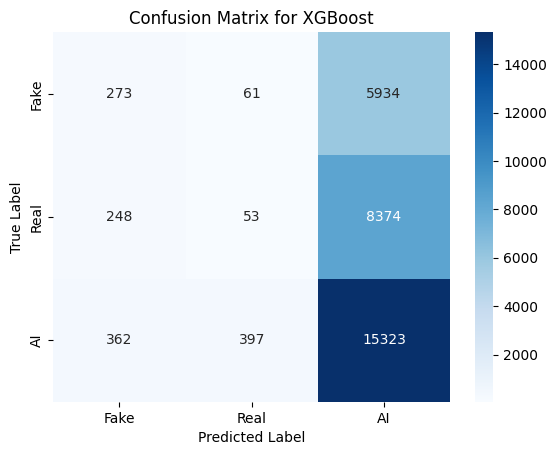

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define a custom scorer function for early stopping
def custom_scorer(estimator, X, y):
    early_stopping_rounds = 10
    early_stopping_monitor = xgb.callback.EarlyStopping(rounds=early_stopping_rounds, metric_name='mlogloss')

    estimator.fit(X, y, eval_set=[(X_val_news_tfidf, y_val)], verbose=False, callbacks=[early_stopping_monitor])
    y_pred = estimator.predict(X_val_news_tfidf)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

# Define the XGBoost model with GPU support
clf = xgb.XGBClassifier(tree_method='hist', device='cuda', random_state=42)

# Define a smaller hyperparameter grid for GridSearch
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3]
}

# Perform GridSearch cross-validation with early stopping
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring=custom_scorer, verbose=2)
grid_search.fit(X_train_news_tfidf, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Subsample a portion of the training data
X_train_sub, _, y_train_sub, _ = train_test_split(X_train_news_tfidf, y_train, test_size=0.2, random_state=42)

# Train the final model with the best hyperparameters and early stopping
final_clf = xgb.XGBClassifier(tree_method='hist', device='cuda', random_state=42, **best_params)
final_clf.fit(X_train_sub, y_train_sub, early_stopping_rounds=10, eval_metric='mlogloss', eval_set=[(X_val_news_tfidf, y_val)], verbose=False)

# Predictions on the validation set
y_pred = final_clf.predict(X_val_news_tfidf)

# Calculate evaluation metrics for multiclass classification
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

# Print evaluation metrics
print('XGBoost model Performance:')
print('Best parameters:', best_params)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)

# Plot the confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real', 'AI'], yticklabels=['Fake', 'Real', 'AI'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for XGBoost')
plt.show()

XGBoost Model Performance
Accuracy: 0.8559871071716357
Precision: 0.8823295092744684
Recall: 0.8559871071716357
F1-Score: 0.8528886390894246


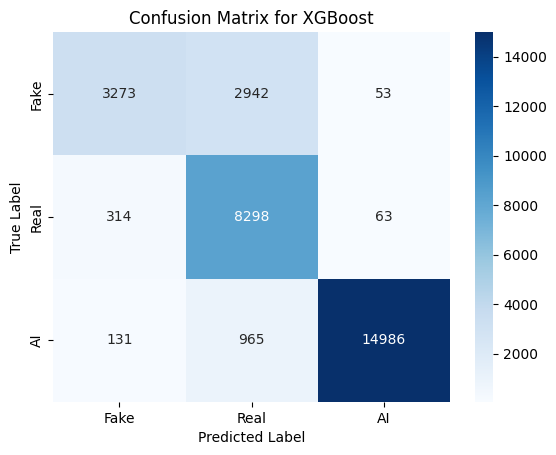

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define the XGBoost model
clf = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=3, subsample=0.8, colsample_bytree=0.8, gamma=0)

# Train the XGBoost model
clf.fit(X_train_news_tfidf, y_train)

# Predictions on the validation set
y_pred = clf.predict(X_val_news_tfidf)

# Calculate evaluation metrics for multiclass classification
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

# Print evaluation metrics
print('XGBoost Model Performance')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)

# Plot the confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real', 'AI'], yticklabels=['Fake', 'Real', 'AI'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for XGBoost')
plt.show()
